# **Imports**

In [ ]:
import os, glob
import shutil
from itertools import combinations
from typing import Union, List, Tuple
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from __future__ import print_function
import time
from skimage.io import imsave
import numpy as np
from keras.models import Model
from tensorflow._api.v2.compat.v1 import image
from keras.backend import expand_dims
from keras.layers import Input, concatenate, Conv2D, Add, MaxPooling2D, Activation, Dense, Reshape, \
    GlobalAveragePooling2D, Multiply, Conv2DTranspose, BatchNormalization, Layer, ReLU, UpSampling2D, Dropout, DepthwiseConv2D, Lambda
from keras import backend as K
from keras.callbacks import *
from keras import optimizers
import matplotlib.pyplot as plt
import tensorflow as tf
import natsort 
from pathlib import Path
import re
import random
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import logging
from tensorflow import keras
from keras import layers
from keras.layers.merge import add,multiply
from tensorflow.keras.models import load_model


# **Tensorflow setup**

In [ ]:
#@title **Tensorflow** **setup**
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

img_rows = 256
img_cols = 256
smooth = 1.

Found GPU at: /device:GPU:0


# **Google Drive connection**

In [ ]:
#@title **Google Drive connection**
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Cyclical Learning Rate**

In [ ]:

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

# **U-Net with VGG-16 Backbone**

In [ ]:

# ---------------------
class unetVgg16:
    def __init__(self):

        """
        This is the __init__ function of Class unet.

        This __init__ function is automatically called when a new instance is
        called. It calles the config file "../condig/modules/unet.json" and sets
        up multiple variables for the unet model.

        Parameters
        ----------
        config_unet : {json file}
            The json file for config_unet.

        Returns
        -------
        {}: {}
        """

        # Seeding.
        self.RSEED = 42
        self.dropout = 0.3

        # Used in self.buildEncoder():
        self.encoder_input_width = 224
        self.encoder_input_channels = 3
        self.encoder_input_shape = (
            self.encoder_input_width,
            self.encoder_input_width,
            self.encoder_input_channels,
        )

        # Used in self.buildUnet():
        self.kernsize = 3
        self.decoder_kernel_size = (self.kernsize, self.kernsize)
        self.stride =2
        self.decoder_strides = (self.stride, self.stride)
        self.decoder_padding = "same"
        self.decoder_activation = None
        self.final_layer_filters = 1
        self.final_layer_activation = 'sigmoid'

    def buildEncoder(self):

        """
        =========
         Encoder
        =========

        Creates the encoder part of the unet by importing pretrained VGG16 from
        Keras API.

        Parameters
        ----------
        {}: {}

        Returns
        -------
        encoder_model: {}
            The encoder part of the Unet (VGG16) with frozen weights pretrained
            from ImageNet dataset and last fully connected layer not included.
        """

        try:
            # Get base model
            VGG16_ = keras.applications.VGG16(
                include_top=False,
                weights="imagenet",
                input_shape=self.encoder_input_shape,
            )

            # Get list of layer names for skip connections later
            layer_names = [layer.name for layer in VGG16_.layers]

            # Get layer outputs
            all_layer_outputs = [
                VGG16_.get_layer(layer_name).output for layer_name in layer_names
            ]

            # Create encoder model
            encoder_model = keras.Model(inputs=VGG16_.input, outputs=all_layer_outputs)

            # Freeze layers
            encoder_model.trainable = False

        except Exception as e:
            # logger.error(f'Unable to buildEncoder!\n{e}')
            print((f"Unable to buildEncoder!\n{e}"))

        return encoder_model

    def buildUnet(self, dropout_training=True):

        """
        ============
         Unet_VGG16
        ============

        Creates the unet (VGG16) based on the following flow:
            - unet_input
                  |
              encoder_model (block)
                  |
              encoded_img (output)
                  |
              decoder_model (block)
                  |
              decoded_img (output)
                  |
              final_up_conv (layer)
                  |
              final_img (output)

            1. Creates input layer (`unet_input`).
                - Uses: Input()
                - Output: `unet_input`
            2. Creates encoder block.
                - Input: `unet_input`
                - Uses: self.buildEncoder()
                - Output: `encoded_img`
            3. Creates decoder block.
                - Input: `encoded_img`
                - Uses: Conv2D(), Conv2DTranspose(), Concatenate()
                - Output: `decoded_img`
            4. Creates final conv layer.
                - Input: `decoded_img`
                - Uses: Conv2D()
                - Output: `final_img`

        The decoder part of the model is the reverse of the VGG16 plus dropout
        layers betwee each block.

        Parameters
        ----------
        dropout_training: {boolean}
            If `True`, dropout layers will be activated (should be True during
            training).
            If `False`, dropout layers will NOT be activated (should be False
            during prediction).

        Returns
        -------
        unet: {}
            The unet model.
        """

        try:
            # =============
            #  Input layer
            # =============

            unet_input = keras.Input(
                shape=self.encoder_input_shape, name="unet_input_layer"
            )

            x = unet_input

            # =========
            #  Encoder
            # =========

            encoder_model = self.buildEncoder()
            all_encoder_layer_outputs = encoder_model(x)

            # Get final encoder output (this will be the input for the decoder)
            encoded_img = all_encoder_layer_outputs[-1]

            # Get outputs to be used for skip connections
            # (I know the specific layers to be used for skip connections)
            skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 5, 9, 13, 17]]

            # =========
            #  Decoder
            # =========

            decoder_filters = int(encoded_img.shape[-1])

            # ------------------------------------------
            # Block 5: 7x7 -> 14x14
            #  - `encoded_img` as initial input for decoder
            x = keras.layers.Conv2DTranspose(
                name="block5_up_convT",
                filters=decoder_filters,
                kernel_size=self.decoder_kernel_size,
                strides=self.decoder_strides,
                padding=self.decoder_padding,
                activation=self.decoder_activation,
            )(encoded_img)

            x = keras.layers.Concatenate(name="block5_up_concat", axis=-1)(
                [x, skip_outputs[4]]
            )

            x = keras.layers.Dropout(
                name="block5_up_dropout", rate=self.dropout, seed=self.RSEED
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block5_up_conv3",
                filters=decoder_filters,
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv2",
                filters=decoder_filters,
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block5_up_conv1",
                filters=decoder_filters,
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 4: 14x14 -> 28x28
            x = keras.layers.Conv2DTranspose(
                name="block4_up_convT",
                filters=decoder_filters,
                kernel_size=self.decoder_kernel_size,
                strides=self.decoder_strides,
                padding=self.decoder_padding,
                activation=self.decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block4_up_concat", axis=-1)(
                [x, skip_outputs[3]]
            )

            x = keras.layers.Dropout(
                name="block4_up_dropout", rate=self.dropout, seed=self.RSEED
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block4_up_conv3",
                filters=decoder_filters,
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv2",
                filters=decoder_filters,
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block4_up_conv1",
                filters=decoder_filters,
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 3: 28x28 -> 56x56
            x = keras.layers.Conv2DTranspose(
                name="block3_up_convT",
                filters=int(decoder_filters / 2),
                kernel_size=self.decoder_kernel_size,
                strides=self.decoder_strides,
                padding=self.decoder_padding,
                activation=self.decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block3_up_concat", axis=-1)(
                [x, skip_outputs[2]]
            )

            x = keras.layers.Dropout(
                name="block3_up_dropout", rate=self.dropout, seed=self.RSEED
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block3_up_conv3",
                filters=int(decoder_filters / 2),
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv2",
                filters=int(decoder_filters / 2),
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block3_up_conv1",
                filters=int(decoder_filters / 2),
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 2: 56x56 -> 112x112
            x = keras.layers.Conv2DTranspose(
                name="block2_up_convT",
                filters=int(decoder_filters / 4),
                kernel_size=self.decoder_kernel_size,
                strides=self.decoder_strides,
                padding=self.decoder_padding,
                activation=self.decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block2_up_concat", axis=-1)(
                [x, skip_outputs[1]]
            )

            x = keras.layers.Dropout(
                name="block2_up_dropout", rate=self.dropout, seed=self.RSEED
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block2_up_conv2",
                filters=int(decoder_filters / 4),
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            x = keras.layers.Conv2D(
                name="block2_up_conv1",
                filters=int(decoder_filters / 4),
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Block 1: 112x112 -> 224x224
            x = keras.layers.Conv2DTranspose(
                name="block1_up_convT",
                filters=int(decoder_filters / 8),
                kernel_size=self.decoder_kernel_size,
                strides=self.decoder_strides,
                padding=self.decoder_padding,
                activation=self.decoder_activation,
            )(x)

            x = keras.layers.Concatenate(name="block1_up_concat", axis=-1)(
                [x, skip_outputs[0]]
            )

            x = keras.layers.Dropout(
                name="block1_up_dropout", rate=self.dropout, seed=self.RSEED
            )(x, training=dropout_training)

            x = keras.layers.Conv2D(
                name="block1_up_conv2",
                filters=int(decoder_filters / 8),
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)
            decoded_img = keras.layers.Conv2D(
                name="block1_up_conv1",
                filters=int(decoder_filters / 8),
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation="relu",
            )(x)

            # ------------------------------------------
            # Final conv layer
            final_img = keras.layers.Conv2D(
                name="final_up_conv",
                filters=self.final_layer_filters,
                kernel_size=self.decoder_kernel_size,
                strides=(1, 1),
                padding="same",
                activation=self.final_layer_activation,
            )(decoded_img)

            # ======
            #  Unet
            # ======

            unet = keras.Model(inputs=unet_input, outputs=final_img, name="Unet_VGG16")

        except Exception as e:
            # logger.error(f'Unable to buildUnet!\n{e}')
            print((f"Unable to buildUnet!\n{e}"))

        return unet

# **Data loader**

In [ ]:
def loadNumpyArrays(folderPath: str, arr, max) -> np.ndarray:
    i = 0

    entries = os.listdir(folderPath)
    entries.sort()
    #print(entries)
    for entry in entries:

      if i==len(arr):
        break

      if ".DS_Store" not in str(entry) and "(1).npy" not in str(entry):

        l = np.load(folderPath + entry)
        #print(l.shape)
        

        
        if "IMG" in folderPath:
            l = np.dstack([l,l,l])
        else:
            # l = np.expand_dims(l, axis = -1)
            pass

        if "IMG" in folderPath:
          # l = tf.keras.applications.vgg16.preprocess_input(l)
          pass
        
        arr[i] = l
        i = i + 1
        if i==max:
          break
    return arr

def _getDatasets(trainingImgDir: str,
                 trainingMaskDir: str,
                 validationImgDir: str,
                 validationMaskDir: str,
                 testingImgDir: str,
                 testingMaskDir: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    trainingImgs, trainingMasks = prepareData(imagesPath = trainingImgDir,
                                              masksPath = trainingMaskDir,
                                              augmentingFactor = None, mode = 'net_data')
    validationImgs, validationMasks = prepareData(imagesPath = validationImgDir,
                                                  masksPath = validationMaskDir,
                                                  augmentingFactor = None, mode = 'net_data')
    testingImgs, testingMasks = prepareData(imagesPath = testingImgDir,
                                            masksPath = testingMaskDir,
                                            augmentingFactor = None, mode = 'net_data')

    return trainingImgs, trainingMasks, validationImgs, validationMasks, testingImgs, testingMasks


def getDatasetArraysForNet() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    trainingImgDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Training-Final-IMG-Arrayss/"
    trainingMaskDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Training-Final-MSK-Arrays/"
    validationImgDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Validation-Final-IMG-Arrays/"
    validationMaskDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Validation-Final-MSK-Arrays/"
    testingImgDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Testing-Final-IMG-Arrays/"
    testingMaskDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Testing-Final-MSK-Arrays/"

    return loadNumpyArrays(folderPath = trainingImgDir, arr = np.ndarray((6749, 256, 256, 3), dtype = 'float32'), max = 6749), \
           loadNumpyArrays(folderPath = trainingMaskDir, arr = np.ndarray((6749, 256, 256,1), dtype = 'uint8'), max = 6749), \
           loadNumpyArrays(folderPath = validationImgDir,
                           arr = np.ndarray((1551, 256, 256, 3), dtype = 'float32'), max = 1551), loadNumpyArrays(
            folderPath = validationMaskDir,
            arr = np.ndarray((1551, 256, 256,1), dtype = 'uint8'), max = 1551), \
           loadNumpyArrays(folderPath = testingImgDir,
                           arr = np.ndarray((835, 256, 256, 3), dtype = 'float32'), max = 835), loadNumpyArrays(
            folderPath = testingMaskDir,
            arr = np.ndarray((835, 256, 256,1), dtype = 'uint8'), max = 835)
                           

data = getDatasetArraysForNet()

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):

        shuffler = np.random.permutation(len(x_set))
        x_set = x_set[shuffler]
        y_set = y_set[shuffler]

        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

# **Attention-Residual Connected U-Net**

In [ ]:
def ConvBNReLU(inputs,
               outputSize,
               filterSize,
               dropout = 0.0,
               strides = 1,
               batchNormalization = False,
               padding = 'same',
               activation = True,
               useBias = False, repeats = 1):
  
    output = inputs
    for _ in range(repeats):

        output = Conv2D(filters = outputSize,
                        kernel_size = filterSize,
                        strides = strides,
                        padding = padding,
                        use_bias = useBias)(output)  # CONV2D

        if batchNormalization is True:
            output = BatchNormalization(axis = 3)(output)

        if activation:
            output = ReLU()(output)  # RELU

    if dropout > 0.0:
        output = Dropout(rate = dropout)(output)

    return output


def ResidualConvBlock(inputs,
                      outputSize,
                      filterSize,
                      dropout = 0,
                      strides = 1,
                      batchNormalization = False,
                      padding = 'same',
                      activation = True,
                      use_bias = False, repeat = 1):
    output = ConvBNReLU(inputs = inputs, outputSize = outputSize,
                        filterSize = filterSize,
                        dropout = dropout,
                        strides = strides,
                        batchNormalization = batchNormalization,
                        padding = padding,
                        activation = activation,
                        useBias = use_bias, repeats = repeat)

    shortcut = Conv2D(outputSize, kernel_size = (1, 1), padding = 'same')(inputs)

    if batchNormalization is True:
        shortcut = BatchNormalization(axis = 3)(shortcut)

    output = Add()([shortcut, output])
    output = SqueezeExciteBlock(inputs = output, inputShape = output.shape)
    return output


def SqueezeExciteBlock(inputs, inputShape, ratio = 8):
    ratio = ratio
    globalAveragePooling2D = GlobalAveragePooling2D()
    squeezeExciteShape = (1, 1, inputShape[-1])
    reshape = Reshape(squeezeExciteShape)
    reLuDenseLayer = Dense(inputShape[-1] // ratio, activation = 'relu',
                           kernel_initializer = 'he_normal',
                           use_bias = False)
    sigmoidDenseLayer = Dense(inputShape[-1],
                              activation = 'sigmoid',
                              kernel_initializer = 'he_normal',
                              use_bias = False)

    squeeze = globalAveragePooling2D(inputs)
    squeeze = reshape(squeeze)
    squeeze = reLuDenseLayer(squeeze)
    squeeze = sigmoidDenseLayer(squeeze)
    output = Multiply()([inputs, squeeze])

    return output


def ASPPBlock(inputs, filters, batchNormalization = True):
    globalAveragePooling2D = GlobalAveragePooling2D()

    inputShape = inputs.get_shape().as_list()
    output = globalAveragePooling2D(inputs)
    output = expand_dims(expand_dims(output, 1), 1)

    output = ConvBNReLU(
            inputs = output,
            outputSize = filters,
            filterSize = (1, 1),
            dropout = 0,
            strides = 1,
            batchNormalization = batchNormalization,
            padding = 'same',
            activation = True,
            useBias = not batchNormalization)

    output = Lambda(lambda i: image.resize(i, inputShape[1:3], method = 'bilinear', align_corners = True))(output)

    output0 = ConvBNReLU(
            inputs = inputs,
            outputSize = filters,
            filterSize = (1, 1),
            dropout = 0,
            strides = 1,
            batchNormalization = batchNormalization,
            padding = 'same',
            activation = True,
            useBias = not batchNormalization)

    # dilation rates are fixed to `[6, 9, 12]`.

    outputD6 = DepthWiseConvBNReLU(filters = filters,
                                   kernelSize = 3,
                                   dilationRate = 6,
                                   batchNormalization = True,
                                   inputs = inputs)
    outputD9 = DepthWiseConvBNReLU(filters = filters,
                                   kernelSize = 3,
                                   dilationRate = 12,
                                   batchNormalization = True,
                                   inputs = inputs)
    outputD12 = DepthWiseConvBNReLU(filters = filters,
                                    kernelSize = 3,
                                    dilationRate = 18,
                                    batchNormalization = True,
                                    inputs = inputs)

    out = concatenate([output, output0, outputD6, outputD9, outputD12])

    y = Conv2D(filters, (1, 1), padding = "same")(out)

    # out = Conv2DTranspose(1024, (2, 2), strides = (2, 2), padding = 'same')(y)
    # print(y.shape)
    return y


def DepthWiseConvBNReLU(inputs,
                        filters,
                        kernelSize = 3,
                        dilationRate = 1,
                        padding = 'same',
                        batchNormalization = False):
    useBias = not batchNormalization
    depthWiseConv2D = DepthwiseConv2D(kernel_size = kernelSize,
                                      dilation_rate = dilationRate,
                                      padding = padding,
                                      use_bias = useBias)

    output = depthWiseConv2D(inputs)

    if batchNormalization:
        output = BatchNormalization(axis = -1)(output)

    output = ReLU()(output)
    output = ConvBNReLU(inputs = output,
                        outputSize = filters,
                        filterSize = kernelSize,
                        dropout = 0,
                        strides = 1,
                        batchNormalization = batchNormalization,
                        padding = 'same',
                        activation = True,
                        useBias = not batchNormalization,
                        repeats = 1

                        )

    return output



def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def AttentionBlock(inputs,
                   gatingSignal,
                   interShape):
    inputShape = K.int_shape(inputs)
    gatingShape = K.int_shape(gatingSignal)

    # Getting the inputShape signal to the same shape as the gating signal
    thetaInput = Conv2D(filters = interShape, kernel_size = (2, 2), strides = (2, 2), padding = 'same')(
            inputs)  # 16
    shapeThetaInput = K.int_shape(thetaInput)

    # Getting the gating signal to the same number of filters as the inter_shape
    phiGating = Conv2D(filters = interShape, kernel_size = (1, 1), padding = 'same')(gatingSignal)

    upsampleGating = Conv2DTranspose(filters = interShape,
                                     kernel_size = (3, 3),
                                     strides = (
                                         shapeThetaInput[1] // gatingShape[1],
                                         shapeThetaInput[2] // gatingShape[2]),
                                     padding = 'same')(phiGating)  # 16

    concatInputAndGating = Add()([upsampleGating, thetaInput])

    activateConcatSignal = Activation(activation = 'relu')(concatInputAndGating)
    psi = Conv2D(1, (1, 1), padding = 'same')(activateConcatSignal)

    sigmoidConcatSignal = Activation(activation = 'sigmoid')(psi)
    shapeSigmoidConcat = K.int_shape(sigmoidConcatSignal)

    upsamplePsi = UpSampling2D(
            size = (inputShape[1] // shapeSigmoidConcat[1], inputShape[2] // shapeSigmoidConcat[2]))(
            sigmoidConcatSignal)  # 32

    upsamplePsi = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis = 3),
                         arguments = {'repnum': inputShape[3]})(upsamplePsi)

    output = Multiply()([upsamplePsi, inputs])

    output = Conv2D(filters = inputShape[3], kernel_size = (1, 1), padding = 'same')(output)
    output = BatchNormalization()(output)
    return output


def EncoderBlock1(inputs, convFilterSize, numOfFilters, dropout, batchNormalization):
    conv256 = ResidualConvBlock(outputSize = numOfFilters,
                                filterSize = convFilterSize,
                                dropout = dropout,
                                batchNormalization = batchNormalization, inputs = inputs, repeat = 2)
    maxPooling128 = MaxPooling2D(pool_size = (2, 2))(conv256)

    conv128 = ResidualConvBlock(outputSize = numOfFilters * 2,
                                filterSize = convFilterSize,
                                dropout = dropout,
                                batchNormalization = batchNormalization, inputs = maxPooling128, repeat = 2)
    maxPooling64 = MaxPooling2D(pool_size = (2, 2))(conv128)

    conv64 = ResidualConvBlock(outputSize = numOfFilters * 4,
                               filterSize = convFilterSize,
                               dropout = dropout,
                               batchNormalization = batchNormalization, repeat = 2, inputs = maxPooling64)
    maxPooling32 = MaxPooling2D(pool_size = (2, 2))(conv64)

    conv32 = ResidualConvBlock(outputSize = numOfFilters * 8,
                               filterSize = convFilterSize,
                               dropout = dropout,
                               batchNormalization = batchNormalization, repeat = 2, inputs = maxPooling32)
    maxPooling16 = MaxPooling2D(pool_size = (2, 2))(conv32)

    # conv16 = residualConvBlock16(maxPooling16)

    skips = [conv256, conv128, conv64, conv32]

    return maxPooling16, skips


def EncoderBlock2(inputs, convFilterSize, numOfFilters, dropout, batchNormalization, decoderSkips):
    skip1 = decoderSkips.pop()
    conv256 = ResidualConvBlock(outputSize = numOfFilters,
                                filterSize = convFilterSize,
                                dropout = dropout,
                                batchNormalization = batchNormalization, inputs = inputs, repeat = 2)
    maxPooling128 = MaxPooling2D(pool_size = (2, 2))(conv256)
    concatenate128 = concatenate([Conv2D(filters = numOfFilters * 2, kernel_size = convFilterSize, activation = 'relu',
                                         padding = 'same')(maxPooling128), skip1])

    skip2 = decoderSkips.pop()
    conv128 = ResidualConvBlock(outputSize = numOfFilters * 2,
                                filterSize = convFilterSize,
                                dropout = dropout,
                                batchNormalization = batchNormalization, inputs = concatenate128, repeat = 2)
    maxPooling64 = MaxPooling2D(pool_size = (2, 2))(conv128)
    concatenate64 = concatenate([Conv2D(filters = numOfFilters * 4, kernel_size = convFilterSize, activation = 'relu',
                                        padding = 'same')(maxPooling64), skip2])

    skip3 = decoderSkips.pop()
    conv64 = ResidualConvBlock(outputSize = numOfFilters * 4,
                               filterSize = convFilterSize,
                               dropout = dropout,
                               batchNormalization = batchNormalization, inputs = concatenate64, repeat = 2)

    maxPooling32 = MaxPooling2D(pool_size = (2, 2))(conv64)
    concatenate32 = concatenate([Conv2D(filters = numOfFilters * 8, kernel_size = convFilterSize, activation = 'relu',
                                        padding = 'same')(maxPooling32), skip3])

    conv32 = ResidualConvBlock(outputSize = numOfFilters * 8,
                               filterSize = convFilterSize,
                               dropout = dropout,
                               batchNormalization = batchNormalization, inputs = concatenate32, repeat = 2)
    maxPooling16 = MaxPooling2D(pool_size = (2, 2))(conv32)

    encoderSkips = [conv256, conv128, conv64, conv32]

    return maxPooling16, encoderSkips


def DecoderBlock(inputs, convFilterSize, numOfFilters, upsamplingFiltersSize, dropout, batchNormalization,
                 encoderSkips):
    ##

    skip1 = encoderSkips.pop()

    gatingSignal32 = ConvBNReLU(outputSize = numOfFilters * 8,
                                filterSize = 1,
                                dropout = dropout,
                                batchNormalization = batchNormalization, inputs = inputs)

    attention32 = AttentionBlock(inputs = skip1,
                                 gatingSignal = gatingSignal32,
                                 interShape = numOfFilters * 8)
    upSample32 = UpSampling2D(size = upsamplingFiltersSize, data_format = "channels_last")(inputs)

    concat32 = concatenate([upSample32, attention32], axis = 3)

    resConv32 = ResidualConvBlock(outputSize = numOfFilters * 8,
                                  filterSize = convFilterSize,
                                  dropout = dropout,
                                  batchNormalization = batchNormalization, inputs = concat32)

    ###
    skip2 = encoderSkips.pop()
    gatingSignal64 = ConvBNReLU(outputSize = numOfFilters * 4,
                                filterSize = 1,
                                dropout = dropout,
                                batchNormalization = batchNormalization, inputs = resConv32)
    attention64 = AttentionBlock(inputs = skip2,
                                 gatingSignal = gatingSignal64,
                                 interShape = numOfFilters * 4)
    upSample64 = UpSampling2D(size = upsamplingFiltersSize, data_format = "channels_last")(resConv32)

    concat64 = concatenate([upSample64, attention64], axis = 3)
    resConv64 = ResidualConvBlock(outputSize = numOfFilters * 4,
                                  filterSize = convFilterSize,
                                  dropout = dropout,
                                  batchNormalization = batchNormalization, inputs = concat64, repeat = 2)

    ###
    skip3 = encoderSkips.pop()
    gatingSignal128 = ConvBNReLU(outputSize = numOfFilters * 2,
                                 filterSize = 1,
                                 dropout = dropout,
                                 batchNormalization = batchNormalization, inputs = resConv64)
    attention128 = AttentionBlock(inputs = skip3,
                                  gatingSignal = gatingSignal128,
                                  interShape = numOfFilters * 2)
    upSample128 = UpSampling2D(size = upsamplingFiltersSize, data_format = "channels_last")(resConv64)

    concat128 = concatenate([upSample128, attention128], axis = 3)
    resConv128 = ResidualConvBlock(outputSize = numOfFilters * 2,
                                   filterSize = convFilterSize,
                                   dropout = dropout,
                                   batchNormalization = batchNormalization, inputs = concat128, repeat = 2)
    ###

    ###
    skip4 = encoderSkips.pop()
    gatingSignal256 = ConvBNReLU(outputSize = numOfFilters,
                                 filterSize = 1,
                                 dropout = dropout,
                                 batchNormalization = batchNormalization, inputs = resConv128)
    attention256 = AttentionBlock(inputs = skip4,
                                  gatingSignal = gatingSignal256,
                                  interShape = numOfFilters * 2)
    upSample256 = UpSampling2D(size = upsamplingFiltersSize, data_format = "channels_last")(resConv128)

    concat256 = concatenate([upSample256, attention256], axis = 3)
    resConv256 = ResidualConvBlock(outputSize = numOfFilters,
                                   filterSize = convFilterSize,
                                   dropout = dropout,
                                   batchNormalization = batchNormalization, inputs = concat256, repeat = 2)
    ###

    decoderSkips = [resConv32, resConv64, resConv128]

    return resConv256, decoderSkips


def AttentionResUNet(inputShape, numClasses = 1, dropoutRate = 0.2, batchNormalization = True):
    convFilterSize = 3
    numOfFilters = 64
    upSamplingFiltersSize = 2

    inputs = Input(shape = inputShape, dtype = tf.float32)

    encoded1, encoderSkips1 = EncoderBlock1(convFilterSize = convFilterSize,
                                            numOfFilters = numOfFilters,
                                            dropout = dropoutRate,
                                            batchNormalization = batchNormalization, inputs = inputs)

    aspp1 = ASPPBlock(filters = 512, batchNormalization = batchNormalization, inputs = encoded1)

    decoded1, decoderSkips1 = DecoderBlock(convFilterSize = convFilterSize,
                                           numOfFilters = numOfFilters,
                                           upsamplingFiltersSize = upSamplingFiltersSize,
                                           dropout = dropoutRate,
                                           batchNormalization = batchNormalization, inputs = aspp1,
                                           encoderSkips = encoderSkips1)

    newInput = concatenate(
            [Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(decoded1), decoded1],
            axis = 3)

    encoded2, encoderSkips2 = EncoderBlock2(convFilterSize = convFilterSize,
                                            numOfFilters = numOfFilters,
                                            dropout = dropoutRate,
                                            batchNormalization = batchNormalization, inputs = newInput,
                                            decoderSkips = decoderSkips1)

    decoded2, decoderSkips2 = DecoderBlock(convFilterSize = convFilterSize,
                                           numOfFilters = numOfFilters,
                                           upsamplingFiltersSize = upSamplingFiltersSize,
                                           dropout = dropoutRate,
                                           batchNormalization = batchNormalization, inputs = encoded2,
                                           encoderSkips = encoderSkips2)

    aspp2 = ASPPBlock(filters = 32, batchNormalization = batchNormalization, inputs = decoded2)

    segmented = Conv2D(filters = numClasses, kernel_size = (1, 1))(aspp2)
    segmented = BatchNormalization(axis = 3)(segmented)
    segmented = Activation('sigmoid')(segmented)

    model = Model(inputs = [inputs], outputs = [segmented])
    return model

# **Metrics & Losses**

In [ ]:
'''
A few useful metrics and losses
'''


smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def iouMetric(y_true, y_pred):

        """
        Calculates the intersection-over-union between a ground truth mask and
        the corresponding predicted mask from the model.
        Parameters
        ----------
        y_true : {tf.Tensor}
            The ground truth mask.
        y_pred : {tf.Tensor}
            Corresponding predicted mask.
        Returns
        -------
        compute_iou() : {tf.numpy_function}
            A function that calculates the IOU metric.
        """

        try:

            def compute_iou(y_true, y_pred):
                intersection = (y_true * y_pred).sum()
                union = y_true.sum() + y_pred.sum() - intersection
                x = (intersection + 1e-15) / (union + 1e-15)
                x = x.astype(np.float32)
                return x

            return tf.numpy_function(compute_iou, [y_true, y_pred], tf.float32)

        except Exception as e:
            # logger.error(f'Unable to iouMetric!\n{e}')
            print((f"Unable to iouMetric!\n{e}"))


def iou_coef(y_true, y_pred, smooth = 1):
    intersection = K.sum(K.abs(y_true * y_pred), axis = [1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis = 0)
    return iou


def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1 - BCE_EXP), 2.) * BCE)
    return focal_loss


ce_w = 0.7
ce_d_w = 0.5
e = K.epsilon()
smooth = 1
'''
ce_w values smaller than 0.5 penalize false positives more while values larger than 0.5 penalize false negatives more
ce_d_w is level of contribution of the cross-entropy loss in the total loss.
'''

def Combo_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    d = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    y_pred_f = K.clip(y_pred_f, e, 1.0 - e)
    out = - (ce_w * y_true_f * K.log(y_pred_f)) + ((1 - ce_w) * (1.0 - y_true_f) * K.log(1.0 - y_pred_f))
    weighted_ce = K.mean(out, axis=-1)
    combo = (ce_d_w * weighted_ce) - ((1 - ce_d_w) * d)
    return combo


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_true_pos = tf.cast(y_true_pos, tf.float32)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

# **Basic U-Net**

In [ ]:
##############################################################
'''
Useful blocks to build Unet
conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)
'''

def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
        
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)

    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.5, batch_norm=True):
    '''
    UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model 
    model = Model(inputs, conv_final, name="UNet")
    # print(model.summary())
    return model

# **Residual Connected U-Net**

In [ ]:
def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y 

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x



def get_rwnet():    
    inputs = Input((img_rows, img_cols, 3))
    
    conv1 = resnet_block(inputs,32 , strides=1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = resnet_block(pool1,64 , strides=1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = resnet_block(pool2, 128, strides=1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = resnet_block(pool3, 256, strides=1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = aspp_block(pool4, 512)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = resnet_block(up6, 256, strides=1)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = resnet_block(up7, 128, strides=1)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = resnet_block(up8, 64, strides=1)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = resnet_block(up9, 32, strides=1)
    
    down10 = concatenate([Conv2D(32, (3, 3), activation='relu', padding='same')(conv9), conv9], axis=3)    
    conv10 = resnet_block(down10, 32, strides=1)  
    pool10 = MaxPooling2D(pool_size=(2, 2))(conv10)

    down11 = concatenate([Conv2D(64, (3, 3), activation='relu', padding='same')(pool10), conv8], axis=3)
    conv11 = resnet_block(down11, 64, strides=1)
    pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
    
    down12 = concatenate([Conv2D(128, (3, 3), activation='relu', padding='same')(pool11), conv7], axis=3)
    conv12 = resnet_block(down12, 128, strides=1)
    pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)

    down13 = concatenate([Conv2D(256, (3, 3), activation='relu', padding='same')(pool12), conv6], axis=3)
    conv13 = resnet_block(down13, 256, strides=1)
    pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
    
    conv14 = aspp_block(pool13, 512)
    
    up15 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv14), conv13], axis=3)
    conv15 = resnet_block(up15, 256, strides=1) 
    
    up16 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv15), conv12], axis=3)
    conv16 = resnet_block(up16, 128, strides=1)      

    up17 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv16), conv11], axis=3)
    conv17 = resnet_block(up17, 64, strides=1)   
    
    up18 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv17), conv10], axis=3)
    conv18 = resnet_block(up18, 32, strides=1)    
    
    conv18 = aspp_block(conv18, 32)
    
    conv19 = Conv2D(1, (1, 1), activation='sigmoid')(conv18)

    model = Model(inputs=[inputs], outputs=[conv19])
    return model

# **Main**

In [ ]:
def main():

    print('-' * 30)
    print('Creating and compiling model...')
    print('-' * 30)
                                                      
    model = get_rwnet()
    print(model.summary())

    name = 'mydata'

    # fname = 'rwnet_cbis_join_weights.h5'
    fname = '/content/drive/MyDrive/weights/weights-improvement-{epoch:02d}.hdf5'
    pred_dir = '/content/drive/MyDrive/weights'

    model_checkpoint = ModelCheckpoint(fname, monitor = 'val_loss', verbose = 1, save_best_only = True, mode='min')

    #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
    #This callback will stop the training when there is no improvement in
    # the validation loss for 6 consecutive epochs.
    
    csv_logger = CSVLogger("/content/drive/MyDrive/report.csv", append=True, separator=';')


    model.compile(optimizer = Adam(learning_rate= 1e-6), loss = focal_tversky_loss , metrics = ['accuracy', tversky, dice_coef])

    print('-' * 30)
    print('Fitting model...')
    print('-' * 30)

    imgs_train, imgs_mask_train, imgs_val, imgs_mask_val, imgs_test, imgs_mask_test_gt = data

    imgs_train = imgs_train / 255.
    imgs_val = imgs_val / 255.
    imgs_test = imgs_test / 255.

    train_gen = DataGenerator(imgs_train, imgs_mask_train, 5)
    val_gen = DataGenerator(imgs_val, imgs_mask_val, 5)

    clr = CyclicLR(
      mode='triangular2',
      base_lr=1e-6, 
      max_lr=1e-4,
      step_size= 8 * (3510 // 5))


    history = model.fit(train_gen, epochs = 200, verbose = 1, 
                          callbacks = [model_checkpoint, csv_logger, early_stop, clr],
                          shuffle = True, validation_data = val_gen, use_multiprocessing = True)


    print('-' * 30)
    print('Loading and preprocessing test data...')
    print('-' * 30)

    print('-' * 30)
    print('Loading saved weights...')
    print('-' * 30)
    model.save_weights(fname)

    print('-' * 30)
    print('Predicting masks on test data...')
    print('-' * 30)

    imgs_mask_test = model.predict(imgs_test, verbose = 1)
    np.save('/content/drive/MyDrive/Dataset-split-arrays_' + name + '_wunet.npy', imgs_mask_test)

    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)

    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)

    ev = model.evaluate(imgs_test, imgs_mask_test_gt)
    tversky, dice_coef = ev[1], ev[2]

    print("tversky score:", dice)
    print("dice score:", iou)

    # l=[]
    # for i in range(len(imgs_test)):
    #    l.append(model.evaluate(imgs_test[i,:].reshape(1,256,256,3), imgs_id_test[i,:].reshape(1,256,256,1))[2])
    #
    # ll = [elt for elt in l if elt>=0.9]
    #
    # np.mean(ll)

    plt.plot(history.history['tversky'])
    plt.plot(history.history['val_tversky'])
    plt.title('model tversky coef')
    plt.ylabel('tversky coef')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch  ')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

19679-INFO-start!


------------------------------
Creating and compiling model...
------------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 256, 256, 3)  0           ['batch_normalization[0][0]']    


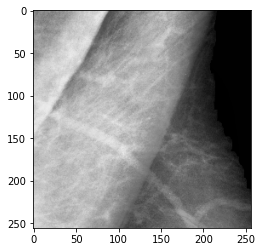

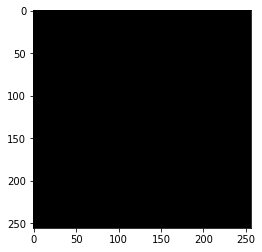

0.9019608


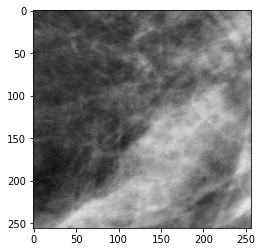

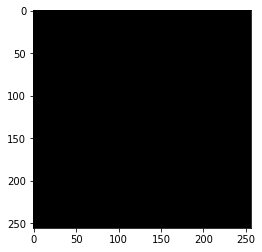

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


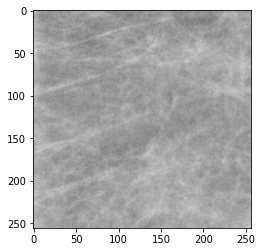

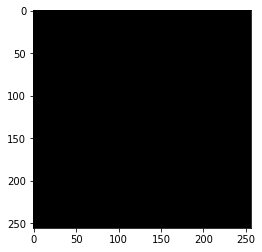

0.89411765


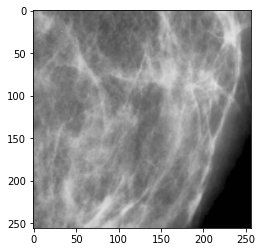

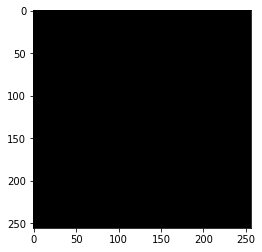

0.8901961


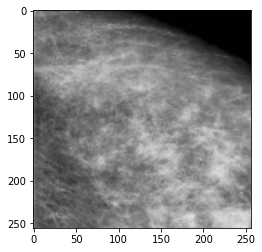

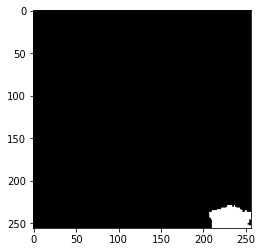

Epoch 1/200
1350/1350 [==============================] - ETA: 0s - loss: 0.7995 - accuracy: 0.8233 - tversky: 0.2489 - dice_coef: 0.1929
Epoch 1: val_loss improved from inf to 0.64909, saving model to /content/drive/MyDrive/weights/weights-improvement-01.hdf5
1350/1350 [==============================] - 456s 313ms/step - loss: 0.7995 - accuracy: 0.8233 - tversky: 0.2489 - dice_coef: 0.1929 - val_loss: 0.6491 - val_accuracy: 0.9747 - val_tversky: 0.4231 - val_dice_coef: 0.3908
Epoch 2/200
1350/1350 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.9692 - tversky: 0.4633 - dice_coef: 0.4160
Epoch 2: val_loss improved from 0.64909 to 0.58682, saving model to /content/drive/MyDrive/weights/weights-improvement-02.hdf5
1350/1350 [==============================] - 414s 307ms/step - loss: 0.6124 - accuracy: 0.9692 - tversky: 0.4633 - dice_coef: 0.4160 - val_loss: 0.5868 - val_accuracy: 0.9819 - val_tversky: 0.4868 - val_dice_coef: 0.4637
Epoch 3/200
1350/1350 [===========

In [ ]:
if __name__ == '__main__':
    logger = logging.getLogger()
    logging.basicConfig(format = '%(process)d-%(levelname)s-%(message)s', level = logging.INFO)
    logger.info("start!")
    start_time = time.time()
    main()
    logger.info("--- %s seconds ---" % (time.time() - start_time))